In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils import Bernoulli, WindowAvgModel

In [2]:
class RepeatModel:
    def __init__(self, repeat_seq, epsilon=1e-7):
        self.repeat_seq = repeat_seq
        self.epsilon = epsilon

    def sample(self, n_samples):
        i = np.random.randint(0, 3)
        x = x * n_samples
        x = x[i:i+n_samples]
        return x

    def log_probability(self, x):
        x_pred = x * len(x)
        x_preds = [x_pred[i:i+len(x)] for i in range(3)]
        
        if x in x_preds:
            return np.log(1/3)
        else:
            return np.log(self.epsilon)


def soft_max(y_h, h_x, temp=1.0):
    h_x = h_x ** temp
    h_x = h_x / h_x.sum()
    return y_h[0] * h_x[0] + y_h[1] * h_x[1]

In [3]:
concept = [0, 1]   # concept we're going to plot 
x_len = 104        # amount of data |x|  (x-axis)

p_non = .25        # prior for non-random hypothesis: p(non-random) / p(random OR non-random)

y_len = 5          # |y| for predictive distributions p(y | __)


p = np.mean(concept)   # p(Tails)
x = concept * x_len
x = x[:x_len]

model_bern = Bernoulli(p=p)
model_window = WindowAvgModel(goal_p=p, window_size=5)
model_concept = RepeatModel(concept)

rows = []
for i in range(1, x_len-y_len + 1):
    x_ = x[:i]
    rows.append({
        'i': i+1,
        'Bernoulli': np.exp(model_bern.log_probability(x_)) * (1 - p_non),
        'Window': np.exp(model_window.log_probability(x_)) * (1 - p_non),
        'Concept': np.exp(model_concept.log_probability(x_)) * p_non,
        
        'Bernoulli_pred': np.exp(model_bern.log_probability(   x[i:i+y_len])),
        'Window_pred':    np.exp(model_window.log_probability( x[i:i+y_len])),
        'Concept_pred':   np.exp(model_concept.log_probability(x[i:i+y_len]))
    })

df_p = pd.DataFrame(rows)


h_x_ = np.array([df_p['Bernoulli'], df_p['Concept']])
h_x = h_x_ / h_x_.sum(axis=0)

y_h = np.array([[.5, 1.0]] * h_x.shape[1]).T

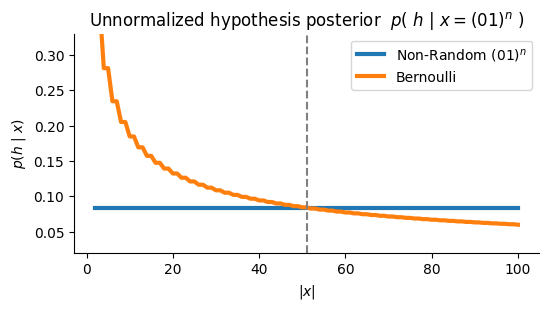

In [4]:
plt.rcParams['figure.figsize'] = (6, 3)

sns.lineplot(x=df_p['i'], y=h_x_[1], label='Non-Random (01)$^n$', lw=3)
sns.lineplot(x=df_p['i'], y=h_x_[0], label='Bernoulli', lw=3)
plt.title('Unnormalized hypothesis posterior  $p( \ h \ | \  x = ($01$)^n \ )$')
plt.ylabel('$p(h \ | \ x)$')
plt.xlabel('$|x|$')

plt.vlines(51, .02, .33, ls='--', color='grey')
plt.ylim(.02, .33)
sns.despine()
plt.subplots_adjust(bottom=0.15)

# plt.savefig('imgs/fig_bms-h_x-unnorm.pdf')
plt.show()

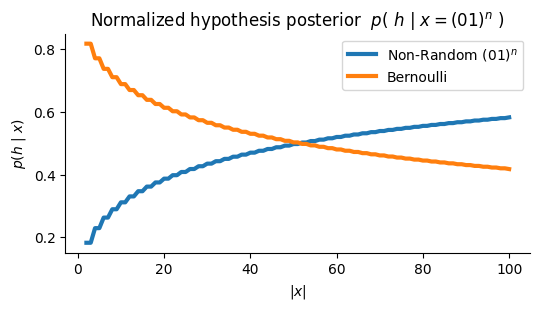

In [5]:
sns.lineplot(x=df_p['i'], y=h_x[1], label='Non-Random (01)$^n$', lw=3)
sns.lineplot(x=df_p['i'], y=h_x[0], label='Bernoulli', lw=3)
plt.title('Normalized hypothesis posterior  $p( \ h \ | \  x = ($01$)^n \ )$')
plt.ylabel('$p(h \ | \ x)$')
plt.xlabel('$|x|$')
plt.subplots_adjust(bottom=0.15)

sns.despine()
# plt.savefig('imgs/fig_bms-h_x-norm.pdf')
plt.show()

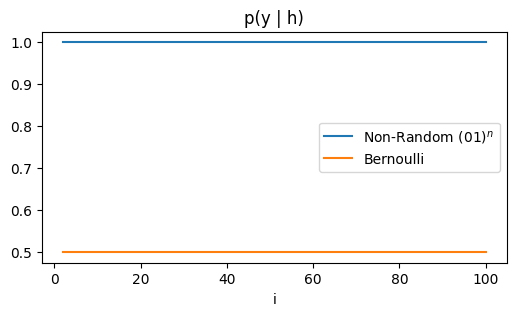

In [6]:
sns.lineplot(x=df_p['i'], y=y_h[1], label='Non-Random (01)$^n$')
sns.lineplot(x=df_p['i'], y=y_h[0], label='Bernoulli')
plt.title('p(y | h)')
plt.show()

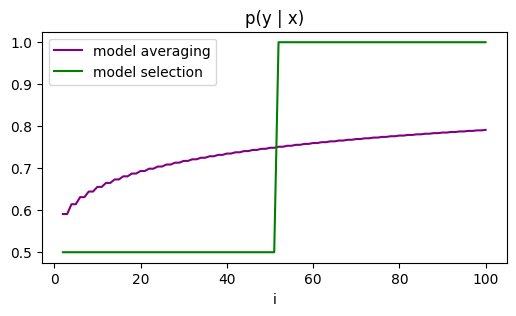

In [7]:
sns.lineplot(x=df_p['i'], y=[(y_h[0][i]*h_x[0][i] + y_h[1][i]*h_x[1][i]) for i in range(h_x.shape[1])], 
             label='model averaging', color='purple')
sns.lineplot(x=df_p['i'], y=[y_h[h][i] for i, h in enumerate(h_x.argmax(axis=0))], 
             label='model selection', color='green')
plt.title('p(y | x)')
plt.show()

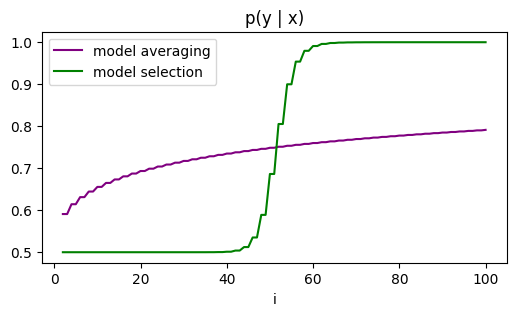

In [8]:
sns.lineplot(x=df_p['i'], y=[(y_h[0][i]*h_x[0][i] + y_h[1][i]*h_x[1][i]) for i in range(h_x.shape[1])], 
             label='model averaging', color='purple')
sns.lineplot(x=df_p['i'], y=[
        soft_max(y_h[:, i], h_x[:, i], temp=50) 
        for i in range(y_h.shape[1])], 
             label='model selection', color='green')
plt.title('p(y | x)')
plt.show()

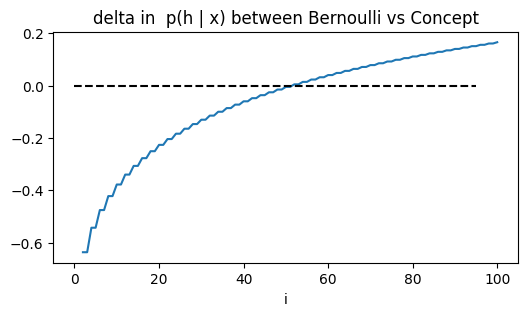

In [9]:
sns.lineplot(x=df_p['i'], y=h_x[1] - h_x[0])
plt.hlines(0, 0, 95, color='black', ls='--')
plt.title('delta in  p(h | x) between Bernoulli vs Concept')
plt.show()

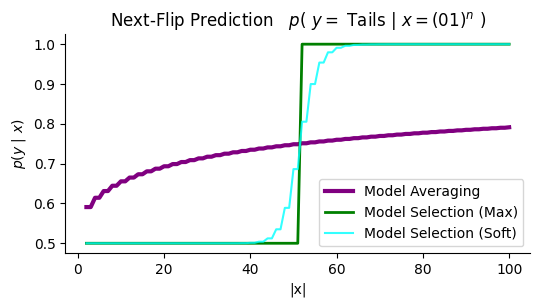

In [10]:
plt.rcParams['figure.figsize'] = (6, 3)

temp = 50

sns.lineplot(x=df_p['i'], y=[(y_h[0][i]*h_x[0][i] + y_h[1][i]*h_x[1][i]) for i in range(h_x.shape[1])], 
             label='Model Averaging', color='purple', lw=3)
sns.lineplot(x=df_p['i'], y=[y_h[h][i] for i, h in enumerate(h_x.argmax(axis=0))], 
             label='Model Selection (Max)', color='green', lw=2)

sns.lineplot(x=df_p['i'], y=[
        soft_max(y_h[:, i], h_x[:, i], temp=temp) 
        for i in range(y_h.shape[1])], 
     label=f'Model Selection (Soft)', color='cyan', alpha=.8)  #, ls=':', lw=3)


plt.title('Next-Flip Prediction   $p( \ y = $ Tails $ | \  x = ($01$)^n \ )$')
plt.xlabel('|x|')
plt.ylabel('$p(y \ | \ x)$')
plt.legend(loc='lower right')
plt.subplots_adjust(bottom=0.15)
sns.despine()

# plt.savefig('imgs/fig_bms-y_x.pdf')
plt.show()

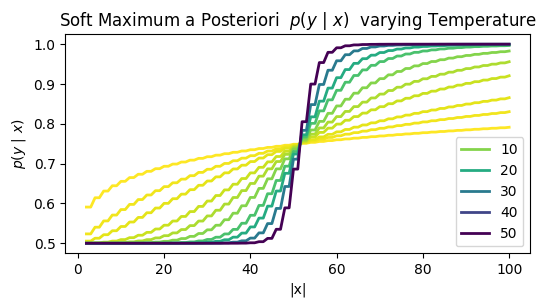

In [11]:
temps = [1, 2, 3, 5, 7, 10, 15, 20, 30, 50]
palette = sns.color_palette('rocket', n_colors=len(temps))

rows = []
for j, temp in enumerate(temps):
    x = df_p['i']
    y = [soft_max(y_h[:, i], h_x[:, i], temp=temp) 
         for i in range(y_h.shape[1])]
    rows += [{'x': x_, 'y': y_, 'Temperature': temp} for x_, y_ in zip(x, y)]
    
fig = sns.lineplot(data=pd.DataFrame(rows), x='x', y='y', hue='Temperature', palette='viridis_r', lw=2)


plt.title('Soft Maximum a Posteriori  $p(y \ | \ x)$  varying Temperature')
new_labs = ['1', '5', '10', '20', '50']


plt.xlabel('|x|')
plt.ylabel('$p(y \ | \ x)$')
plt.legend(loc='lower right')
plt.subplots_adjust(bottom=0.15)

# plt.savefig('imgs/fig_bms-y_x-temp.pdf')
plt.show()